# Part 1: Importing the Dataset
Code for importing data and constructing the FFNN are taken from the numpy tutorial: https://numpy.org/numpy-tutorials/tutorial-deep-learning-on-mnist/#id-1-load-the-mnist-dataset

First, define the file names that will be used for the dataset.

In [22]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

Create the directory if it doesn't exist. Then, download the dataset if it does not exist.

In [23]:
import requests
import os

data_dir = "./_data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://ossci-datasets.s3.amazonaws.com/mnist/"

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print("Downloading file: " + fname)
        resp = requests.get(base_url + fname, stream=True)
        resp.raise_for_status()  # Ensure download was succesful
        with open(fpath, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=128):
                fh.write(chunk)

Decompress data and store as arrays.

In [24]:
import gzip
import numpy as np

mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

Split the data in to training and test sets.

In [25]:
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

Verify that the data was imported correctly.

Matplotlib is building the font cache; this may take a moment.


The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)


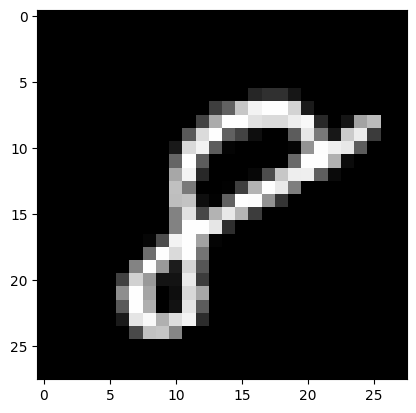

In [26]:
import matplotlib.pyplot as plt

print(
    "The shape of training images: {} and training labels: {}".format(
        x_train.shape, y_train.shape
    )
)
print(
    "The shape of test images: {} and test labels: {}".format(
        x_test.shape, y_test.shape
    )
)

# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap="gray")
# Display the image.
plt.show()

# Part 2: Data Preprocessing

First, convert images to floating point.

In [27]:
# Check type of images before preprocessing
print("The data type of training images: {}".format(x_train.dtype))
print("The data type of test images: {}".format(x_test.dtype))

# Convert to floating point
training_sample, test_sample = 1000, 1000
training_images = x_train[0:training_sample] / 255
test_images = x_test[0:test_sample] / 255

# Check type of images after preprocessing
print("The data type of training images: {}".format(training_images.dtype))
print("The data type of test images: {}".format(test_images.dtype))

The data type of training images: uint8
The data type of test images: uint8
The data type of training images: float64
The data type of test images: float64


Then, convert labels to one-hot encoding.

In [28]:
# Check type of labels before preprocessing
print("The data type of training labels: {}".format(y_train.dtype))
print("The data type of test labels: {}".format(y_test.dtype))

def one_hot_encoding(labels, dimension=10):
    # Define a one-hot variable for an all-zero vector
    # with 10 dimensions (number labels from 0 to 9).
    one_hot_labels = labels[..., None] == np.arange(dimension)[None]
    # Return one-hot encoded labels.
    return one_hot_labels.astype(np.float64)

training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])

# Check type of labels after preprocessing
print("The data type of training labels: {}".format(training_labels.dtype))
print("The data type of test labels: {}".format(test_labels.dtype))

The data type of training labels: uint8
The data type of test labels: uint8
The data type of training labels: float64
The data type of test labels: float64


# Part 3: Defining the Example FFNN

First, set a random seed and hyperparameters.

In [31]:
seed = 884736743
rng = np.random.default_rng(seed)

learning_rate = 0.005
epochs = 20
hidden_size = 100
pixels_per_image = 784
num_labels = 10

def relu(Z):
    return np.maximum(Z, 0)

def generate_weights(pixels_per_image, hidden_size, num_labels, n_hidden, rng):
    weights, biases = [], []

    weights.append(0.2 * rng.random((pixels_per_image, hidden_size)) - 0.1)
    biases.append(0.2 * rng.random(hidden_size) - 0.1)

    for _ in range(n_hidden - 1):
        weights.append(0.2 * rng.random((hidden_size, hidden_size)) - 0.1)
        biases.append(0.2 * rng.random(hidden_size) - 0.1)

    weights.append(0.2 * rng.random((hidden_size, num_labels)) - 0.1)
    biases.append(0.2 * rng.random(num_labels))

    return weights, biases

weights, biases = generate_weights(pixels_per_image, hidden_size, num_labels, 0, rng)


Then, train the model

In [35]:
def relu2deriv(output):
    return output >= 0

weights_1, weights_2 = weights

# To store training and test set losses and accurate predictions
# for visualization.
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

# This is a training loop.
# Run the learning experiment for a defined number of epochs (iterations).
for j in range(epochs):

    #################
    # Training step #
    #################

    # Set the initial loss/error and the number of accurate predictions to zero.
    training_loss = 0.0
    training_accurate_predictions = 0

    # For all images in the training set, perform a forward pass
    # and backpropagation and adjust the weights accordingly.
    for i in range(len(training_images)):
        # Forward propagation/forward pass:
        # 1. The input layer:
        #    Initialize the training image data as inputs.
        layer_0 = training_images[i]
        # 2. The hidden layer:
        #    Take in the training image data into the middle layer by
        #    matrix-multiplying it by randomly initialized weights.
        layer_1 = np.dot(layer_0, weights_1)
        # 3. Pass the hidden layer's output through the ReLU activation function.
        layer_1 = relu(layer_1)
        # 4. Define the dropout function for regularization.
        dropout_mask = rng.integers(low=0, high=2, size=layer_1.shape)
        # 5. The output layer:
        #    Ingest the output of the middle layer into the the final layer
        #    by matrix-multiplying it by randomly initialized weights.
        #    Produce a 10-dimension vector with 10 scores.
        layer_2 = np.dot(layer_1, weights_2)

        # Backpropagation/backward pass:
        # 1. Measure the training error (loss function) between the actual
        #    image labels (the truth) and the prediction by the model.
        training_loss += np.sum((training_labels[i] - layer_2) ** 2)
        # 2. Increment the accurate prediction count.
        training_accurate_predictions += int(
            np.argmax(layer_2) == np.argmax(training_labels[i])
        )
        # 3. Differentiate the loss function/error.
        layer_2_delta = training_labels[i] - layer_2
        # 4. Propagate the gradients of the loss function back through the hidden layer.
        layer_1_delta = np.dot(weights_2, layer_2_delta) * relu2deriv(layer_1)
        # 5. Apply the dropout to the gradients.
        layer_1_delta *= dropout_mask
        # 6. Update the weights for the middle and input layers
        #    by multiplying them by the learning rate and the gradients.
        weights_1 += learning_rate * np.outer(layer_0, layer_1_delta)
        weights_2 += learning_rate * np.outer(layer_1, layer_2_delta)

    # Store training set losses and accurate predictions.
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)

    ###################
    # Evaluation step #
    ###################

    # Evaluate model performance on the test set at each epoch.

    # Unlike the training step, the weights are not modified for each image
    # (or batch). Therefore the model can be applied to the test images in a
    # vectorized manner, eliminating the need to loop over each image
    # individually:

    results = relu(test_images @ weights_1) @ weights_2

    # Measure the error between the actual label (truth) and prediction values.
    test_loss = np.sum((test_labels - results) ** 2)

    # Measure prediction accuracy on test set
    test_accurate_predictions = np.sum(
        np.argmax(results, axis=1) == np.argmax(test_labels, axis=1)
    )

    # Store test set losses and accurate predictions.
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)

    # Summarize error and accuracy metrics at each epoch
    print(
        (
            f"Epoch: {j}\n"
            f"  Training set error: {training_loss / len(training_images):.3f}\n"
            f"  Training set accuracy: {training_accurate_predictions / len(training_images)}\n"
            f"  Test set error: {test_loss / len(test_images):.3f}\n"
            f"  Test set accuracy: {test_accurate_predictions / len(test_images)}"
        )
    )

Epoch: 0
  Training set error: 0.705
  Training set accuracy: 0.573
  Test set error: 0.653
  Test set accuracy: 0.628
Epoch: 1
  Training set error: 0.513
  Training set accuracy: 0.792
  Test set error: 0.596
  Test set accuracy: 0.69
Epoch: 2
  Training set error: 0.463
  Training set accuracy: 0.82
  Test set error: 0.574
  Test set accuracy: 0.72
Epoch: 3
  Training set error: 0.427
  Training set accuracy: 0.845
  Test set error: 0.549
  Test set accuracy: 0.732
Epoch: 4
  Training set error: 0.399
  Training set accuracy: 0.86
  Test set error: 0.532
  Test set accuracy: 0.755
Epoch: 5
  Training set error: 0.383
  Training set accuracy: 0.865
  Test set error: 0.516
  Test set accuracy: 0.762
Epoch: 6
  Training set error: 0.366
  Training set accuracy: 0.883
  Test set error: 0.507
  Test set accuracy: 0.755
Epoch: 7
  Training set error: 0.355
  Training set accuracy: 0.881
  Test set error: 0.501
  Test set accuracy: 0.771
Epoch: 8
  Training set error: 0.347
  Training set 

Visualize the training results

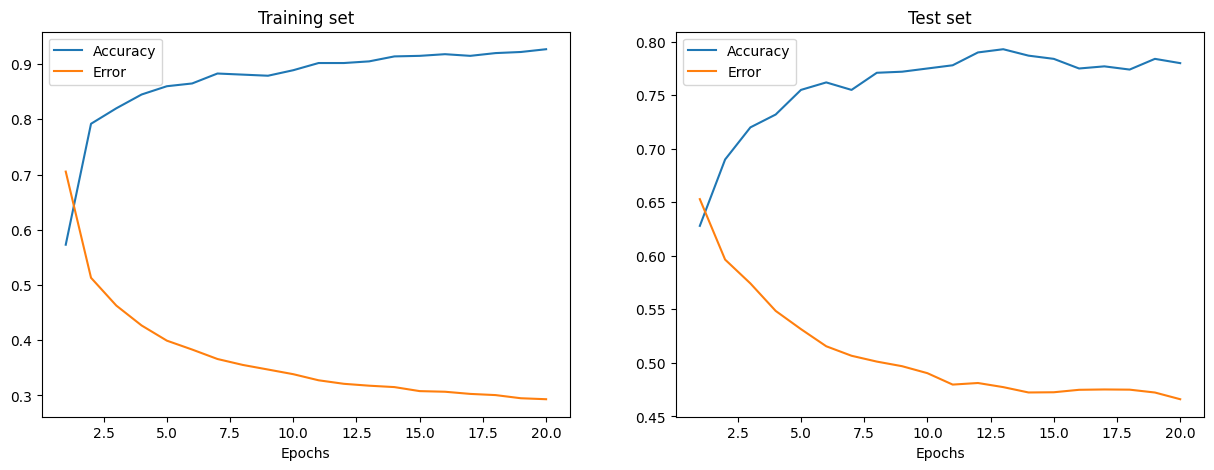

In [36]:
epoch_range = np.arange(epochs) + 1  # Starting from 1

# The training set metrics.
training_metrics = {
    "accuracy": np.asarray(store_training_accurate_pred) / len(training_images),
    "error": np.asarray(store_training_loss) / len(training_images),
}

# The test set metrics.
test_metrics = {
    "accuracy": np.asarray(store_test_accurate_pred) / len(test_images),
    "error": np.asarray(store_test_loss) / len(test_images),
}

# Display the plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, metrics, title in zip(
    axes, (training_metrics, test_metrics), ("Training set", "Test set")
):
    # Plot the metrics
    for metric, values in metrics.items():
        ax.plot(epoch_range, values, label=metric.capitalize())
    ax.set_title(title)
    ax.set_xlabel("Epochs")
    ax.legend()
plt.show()